In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../"))
from pathlib import Path
this_path = Path().resolve()
import numpy as np
import torch
import SimpleITK as sitk
import pandas as pd
import nibabel as nib
import pytorch_lightning as pl
import torchio as tio
import matplotlib.pyplot as plt
import yaml
import seaborn as sns

from dataset.hmri_dataset import HMRIControlsDataModule, HMRIPDDataModule
from models.pl_model import Model_AE
from utils.utils import save_nifti_from_array


In [2]:
def reconstruct(data, model, ckpt_path, overlap_mode='crop', save_img=False, out_dir=None, type='pd'):
    patches, locations, sampler, subject, subj_id = data
    input_imgs = patches.to(model.device)
    aggregator = tio.data.GridAggregator(sampler, overlap_mode=overlap_mode)  
    with torch.no_grad():
        x_hat = model(input_imgs)
    aggregator.add_batch(x_hat, locations)
    reconstructed = aggregator.get_output_tensor()

    # Compute reconstruction error
    subject = subject['image'][tio.DATA]
    diff = [torch.pow(subject[i] - reconstructed[i], 2) for i in range(subject.shape[0])]
    rerror = torch.sqrt(torch.sum(torch.stack(diff), dim=0))
    rerror = rerror.cpu().numpy()
    
    if out_dir is None:
        out_dir = Path('/home/alejandrocu/Documents/parkinson_classification/reconstructions') / Path(ckpt_path).parent.parent.parent.name
        out_dir.mkdir(parents=True, exist_ok=True)
        
    if save_img:
        save_nifti_from_array(subj_id=subj_id,
                              arr=reconstructed[0].cpu().numpy(),
                              path=out_dir / f'{type}_{subj_id}_recon.nii.gz')
        save_nifti_from_array(subj_id=subj_id,
                              arr=rerror,
                              path=out_dir / f'{type}_{subj_id}_re_error.nii.gz')
        save_nifti_from_array(subj_id=subj_id,
                              arr=subject[0].cpu().numpy(),
                              path=out_dir / f'{type}_{subj_id}_original.nii.gz')
    
    return rerror

In [38]:
hc_idx = 1
pd_idx = 1
overlap = 6 # even number in pixel units
ckpt_path = Path('/home/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/aehmri-da00_bz32_l1_adam_lr0.001_sch120/version_0/checkpoints/epoch=175-val_loss=0.0361-val_mse=0.0051.ckpt')

In [39]:
# read config file
exp_dir = ckpt_path.parent.parent.parent
with open(exp_dir /'config_dump.yml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

# create dataset
root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path.parent/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_pd = md_df[md_df['group'] == 1]
data = HMRIControlsDataModule(md_df=md_df_hc,
                                root_dir=root_dir, 
                                **cfg['dataset'])
data.prepare_data()
data.setup()
hc_patches, hc_locations, hc_sampler, hc_subject = data.get_grid(subj=hc_idx, overlap=overlap)
hc_subj_id = data.md_df_train.iloc[hc_idx]['id']

hc_data = [hc_patches, hc_locations, hc_sampler, hc_subject, hc_subj_id]

data_pd = HMRIPDDataModule(md_df=md_df_pd,
                            root_dir=root_dir,  
                            **cfg['dataset'])
data_pd.prepare_data()
data_pd.setup()
pd_patches, pd_locations, pd_sampler, pd_subject = data_pd.get_grid(subj=pd_idx, overlap=overlap)

pd_subj_id = data_pd.md_df.iloc[pd_idx]['id']

pd_data = [pd_patches, pd_locations, pd_sampler, pd_subject, pd_subj_id]
# create model
model = Model_AE.load_from_checkpoint(ckpt_path, net='autoencoder', **cfg['model'])
model = model.to('cuda')
model.eval()

/home/alejandrocu/Documents/parkinson_classification/dataset/hmri_dataset.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.md_df.drop(self.md_df[self.md_df.id == drop_id].index, inplace=True)


Drop subjects ['sub-058', 'sub-016', 'sub-025']


Model_AE(
  (criterion): L1Loss()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
  (train_auroc): BinaryAUROC()
  (val_auroc): BinaryAUROC()
  (train_f1): BinaryF1Score()
  (val_f1): BinaryF1Score()
  (train_mse): MeanSquaredError()
  (val_mse): MeanSquaredError()
  (net): AutoEncoder(
    (encode): Sequential(
      (encode_0): Convolution(
        (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (adn): ADN(
          (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (A): PReLU(num_parameters=1)
        )
      )
      (encode_1): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (adn): ADN(
          (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (A): PReLU(num_parameters=1)
        )
      )
      (encode_2): Convolution(
        (conv): Conv3d(64, 128

In [18]:
for overlap in ['crop', 'average', 'hann']:
    pd_rerror = reconstruct(pd_data, model, ckpt_path, overlap_mode=overlap, save_img=False, type='pd')
    hc_rerror = reconstruct(hc_data, model, ckpt_path, overlap_mode=overlap, save_img=False, type='hc')
    print(f'Overlap mode: {overlap}')
    print(f'PD reconstruction error: {np.mean(pd_rerror)}, std: {np.std(pd_rerror)}')
    print(f'HC reconstruction error: {np.mean(hc_rerror)}, std: {np.std(hc_rerror)}')


Overlap mode: crop
PD reconstruction error: 0.020443765446543694, std: 0.049914341419935226
HC reconstruction error: 0.017629513517022133, std: 0.05148323252797127
Overlap mode: average
PD reconstruction error: 0.02004263922572136, std: 0.04901799559593201
HC reconstruction error: 0.017400987446308136, std: 0.050745341926813126
Overlap mode: hann
PD reconstruction error: 0.020022844895720482, std: 0.04907464608550072
HC reconstruction error: 0.01734846457839012, std: 0.05073561891913414


In [42]:
re_all = []
for i in range(2):#len(data.md_df_val):    
    for overlap in ['crop', 'average', 'hann']:    
        re_subj = {}    
        hc_patches, hc_locations, hc_sampler, hc_subject = data.get_grid(subj=i, overlap=6, mode='val')
        hc_subj_id = data.md_df_train.iloc[i]['id']
        hc_data = [hc_patches, hc_locations, hc_sampler, hc_subject, hc_subj_id]
        hc_rerror = reconstruct(hc_data, model, ckpt_path, overlap_mode=overlap, save_img=False, type='hc')
        re_subj['overlap'] = overlap
        re_subj['mean_re'] = np.mean(hc_rerror)
        re_subj['id'] = hc_subj_id
        re_subj['group'] = 'hc'
        re_all.append(re_subj)

for i in range(2):#len(data_pd.md_df):    
    for overlap in ['crop', 'average', 'hann']:    
        re_subj = {}    
        pd_patches, pd_locations, pd_sampler, pd_subject = data_pd.get_grid(subj=i, overlap=6)
        pd_subj_id = data_pd.md_df.iloc[i]['id']
        pd_data = [pd_patches, pd_locations, pd_sampler, pd_subject, pd_subj_id]
        pd_rerror = reconstruct(pd_data, model, ckpt_path, overlap_mode=overlap, save_img=False, type='pd')
        re_subj['overlap'] = overlap
        re_subj['mean_re'] = np.mean(pd_rerror)
        re_subj['id'] = pd_subj_id
        re_subj['group'] = 'pd'
        re_all.append(re_subj)
# pd_patches, pd_locations, pd_sampler, pd_subject = data_pd.get_grid(subj=pd_idx, overlap=overlap)

# pd_subj_id = data_pd.md_df.iloc[pd_idx]['id']

# pd_data = [pd_patches, pd_locations, pd_sampler, pd_subject, pd_subj_id]

In [43]:
pd.DataFrame(re_all)

,overlap,mean_re,id,group
0,crop,0.024173,sub-022,hc
1,average,0.023764,sub-022,hc
2,hann,0.023759,sub-022,hc
3,crop,0.017020,sub-027,hc
4,average,0.016678,sub-027,hc
5,hann,0.016670,sub-027,hc
6,crop,0.016879,sub-003,pd
7,average,0.016557,sub-003,pd
8,hann,0.016548,sub-003,pd
9,crop,0.020444,sub-004,pd


### Plots

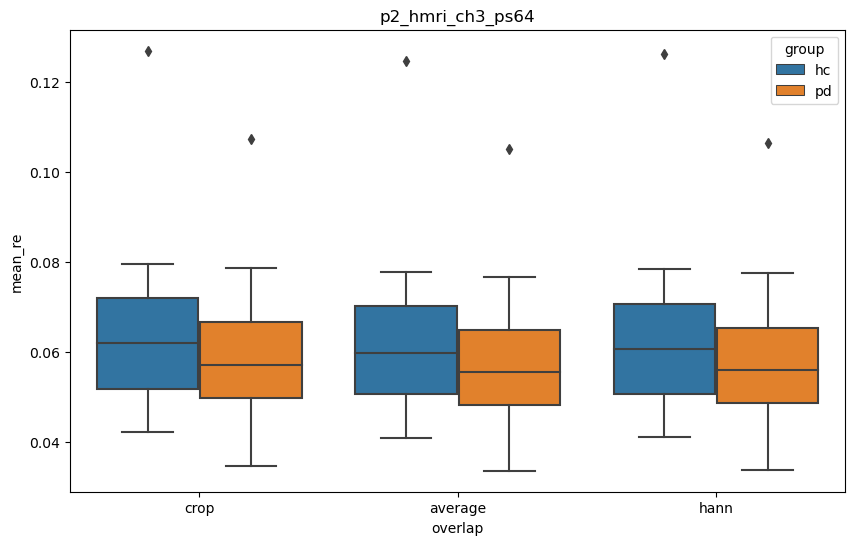

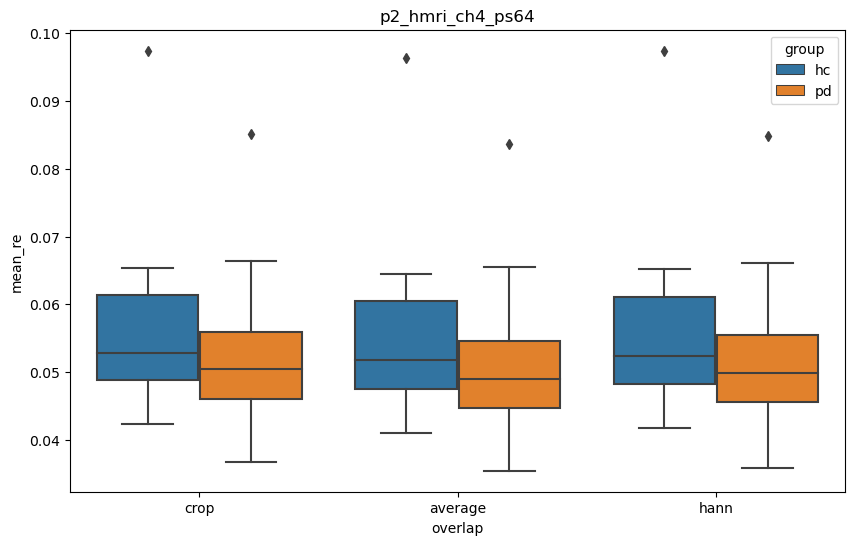

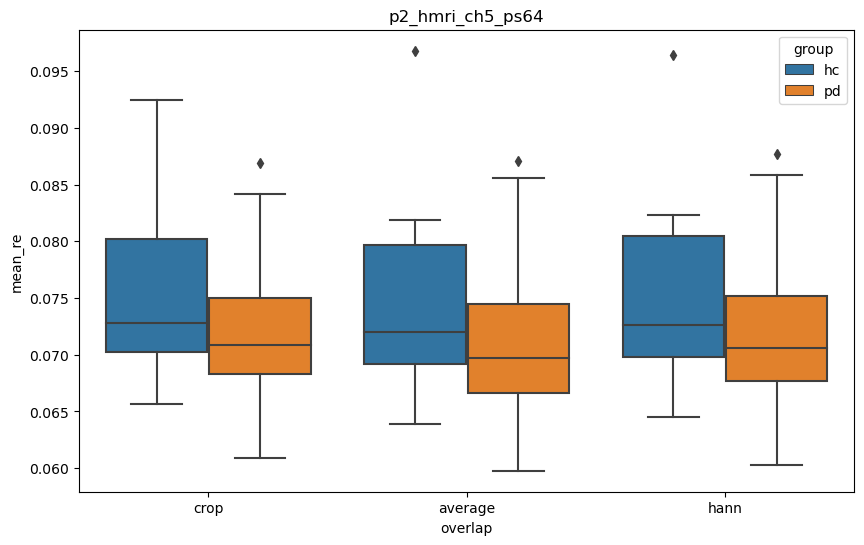

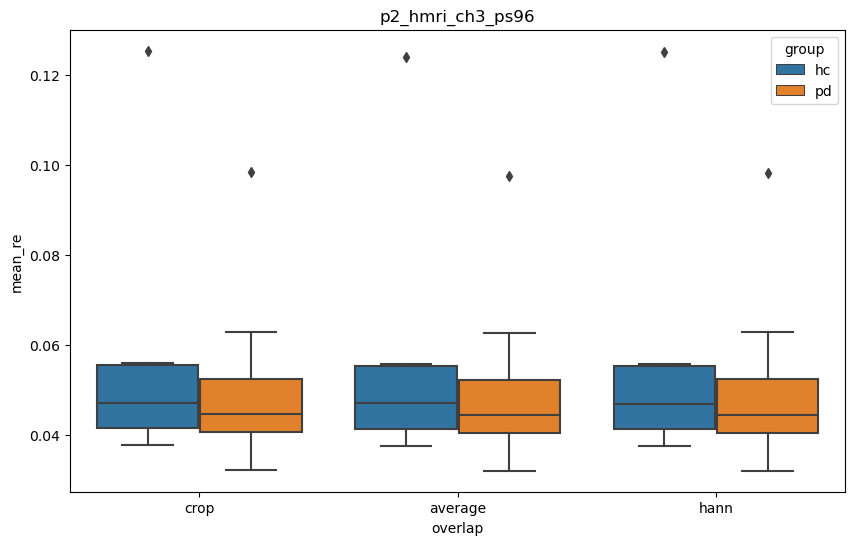

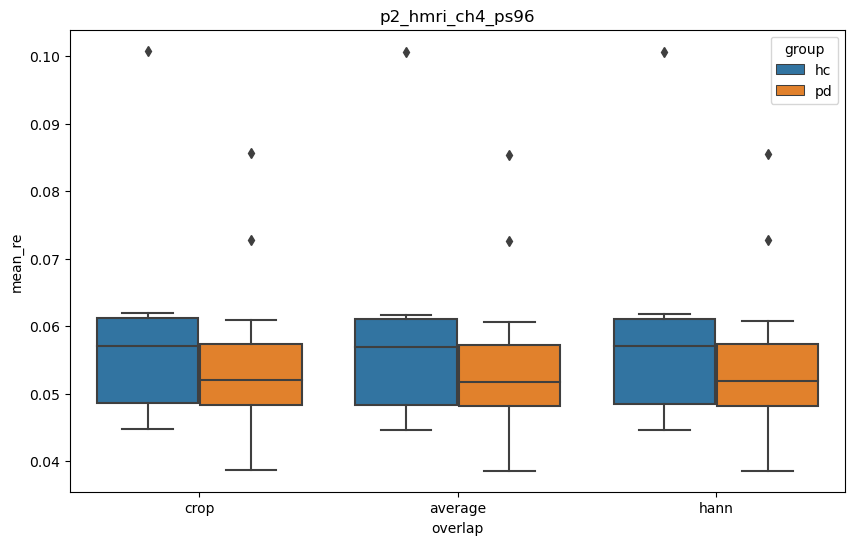

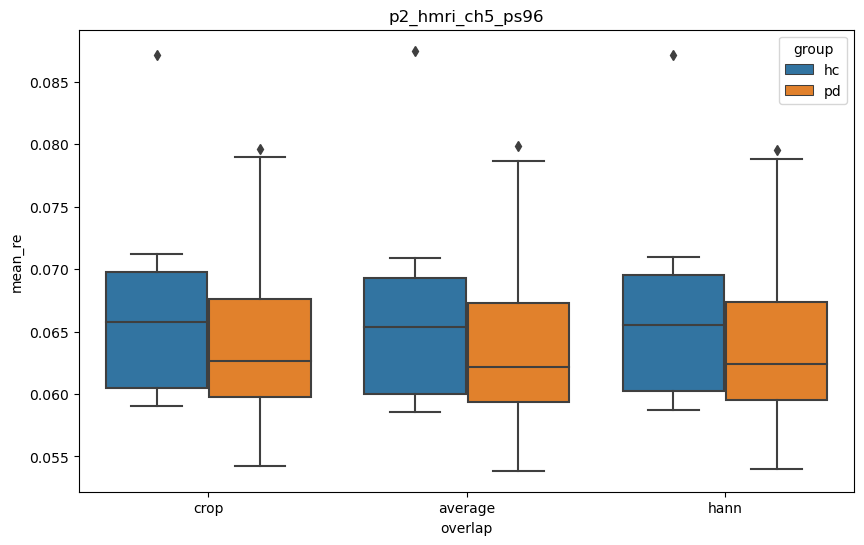

In [9]:
hp_tuning = Path('/home/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/hp_tuning/')
for exp in hp_tuning.iterdir():
    if exp.is_dir():
        data = pd.read_csv(exp/'reconstruction_errors.csv')
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='overlap', y='mean_re', hue='group', data=data)
        plt.title(exp.name)
# data

<Axes: xlabel='overlap', ylabel='mean_re'>

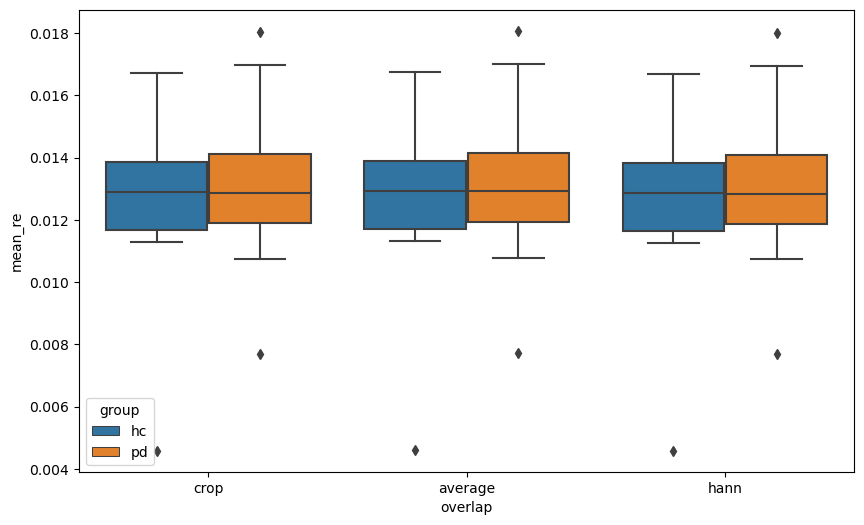

In [10]:
data = pd.read_csv('/home/alejandrocu/Documents/parkinson_classification/reconstructions/p2_hmri_ch3_ps96/reconstruction_errors.csv')
plt.figure(figsize=(10, 6))
sns.boxplot(x='overlap', y='mean_re', hue='group', data=data)

In [11]:
data.group.value_counts()

pd    138
hc     21
Name: group, dtype: int64

<Axes: xlabel='overlap', ylabel='mean_re'>

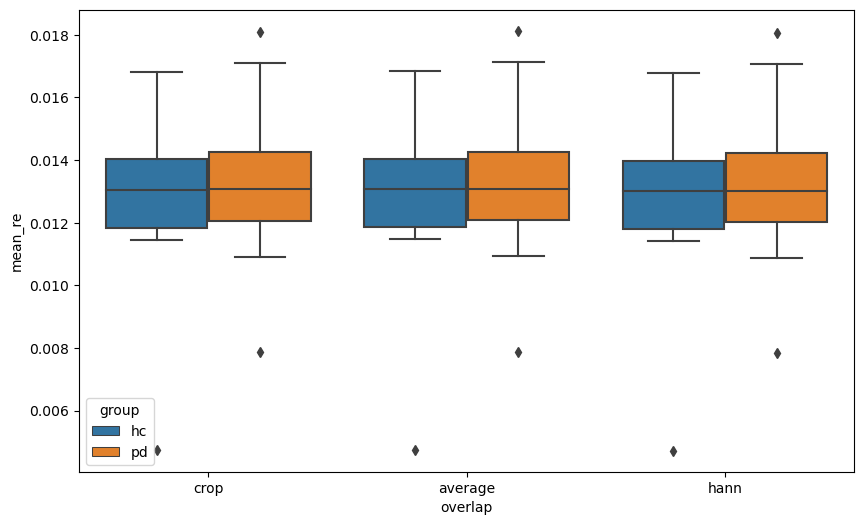

In [13]:
data = pd.read_csv('/home/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/hp_tuning/p2_hmri_ch3_ps96_test/reconstruction_errors.csv')
plt.figure(figsize=(10, 6))
sns.boxplot(x='overlap', y='mean_re', hue='group', data=data)

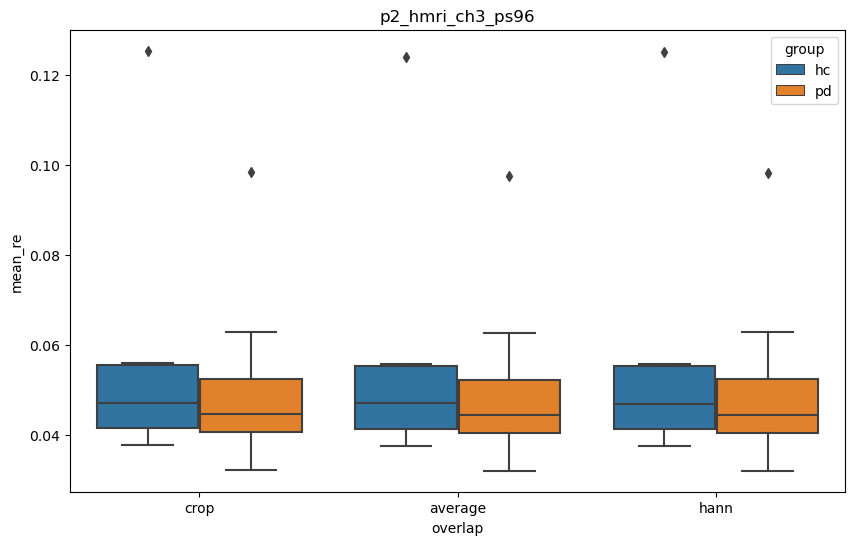

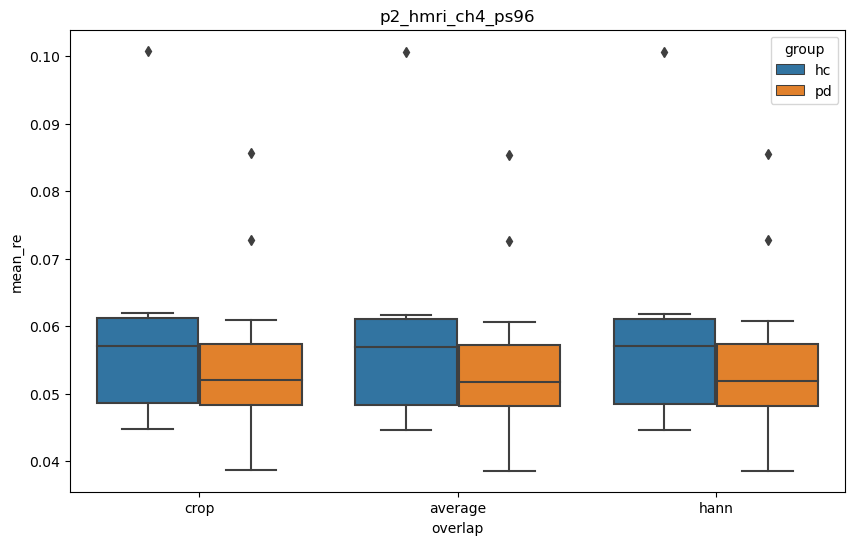

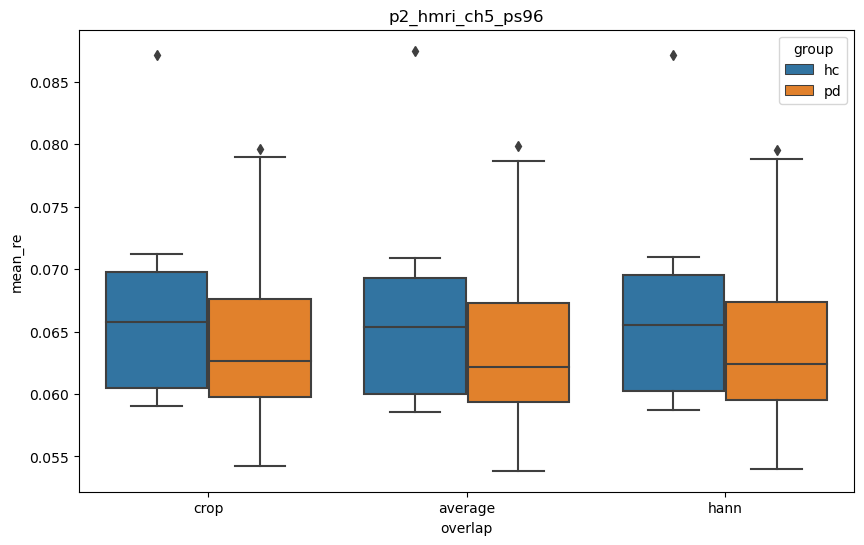

In [15]:
experiments = ['p2_hmri_ch3_ps96', 'p2_hmri_ch4_ps96', 'p2_hmri_ch5_ps96']
for exp in experiments:
    data = pd.read_csv(f'/home/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/hp_tuning/{exp}/reconstruction_errors.csv')
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='overlap', y='mean_re', hue='group', data=data)
    plt.title(exp)

In [ ]:
/home/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/hp_tuning/p2_hmri_ch3_ps64/reconstruction_errors.csv

In [ ]:
/home/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/hp_tuning/p2_hmri_ch3_ps64/reconstruction_errors.csv

In [ ]:
/home/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/hp_tuning/p2_hmri_ch3_ps64/reconstruction_errors.csv

In [ ]:
/home/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/hp_tuning/p2_hmri_ch3_ps64/reconstruction_errors.csv

In [ ]:
/home/alejandrocu/Documents/parkinson_classification/p2_hmri_outs/hp_tuning/p2_hmri_ch3_ps64/reconstruction_errors.csv